# Preprocessing The Data #

There are some techniques we want to use to process the data, but first let's load in the values from the .mat files.

In [78]:
# Import list
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io as sio
import numpy as np
import os
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [12]:
contents = sio.loadmat('data/data.mat') # This is the first file, I think it contains the labels?
for key in contents.keys():
    print "Key : ", key, "\n Values : ", contents[key]

Key :  __version__ 
 Values :  1.0
Key :  data 
 Values :  [[array([[152]], dtype=uint8) array([u'2b'], 
      dtype='<U2')
  array([[ nan]]) ..., array([[ nan]]) array([[5]], dtype=uint8)
  array([[ nan]])]
 [array([[189]], dtype=uint8) array([u'2b'], 
      dtype='<U2')
  array([[ nan]]) ..., array([[ nan]]) array([[4]], dtype=uint8)
  array([[20]], dtype=uint8)]
 [array([[137]], dtype=uint8) array([u'2a'], 
      dtype='<U2')
  array([[ nan]]) ..., array([[ nan]]) array([[5]], dtype=uint8)
  array([[19]], dtype=uint8)]
 ..., 
 [array([], shape=(1, 0), dtype=float64)
  array([], shape=(1, 0), dtype=float64)
  array([], shape=(1, 0), dtype=float64) ...,
  array([], shape=(1, 0), dtype=float64)
  array([], shape=(1, 0), dtype=float64)
  array([], shape=(1, 0), dtype=float64)]
 [array([], shape=(1, 0), dtype=float64)
  array([], shape=(1, 0), dtype=float64)
  array([], shape=(1, 0), dtype=float64) ...,
  array([], shape=(1, 0), dtype=float64)
  array([], shape=(1, 0), dtype=float64)
  a

## What do we see ##
We see a couple different things inside, one strikes our attention:
- "__version__" is the version of the mat
- "__data__" is the data we want
- "__header__" and "__globals__" are empty things we don't really care about.

In [13]:
# Extract the data field
raw_data = contents['data']
# We see there is an array of arbitrary size, sometimes there's 152, nan, 189, etc...
# We see the label (ground truth) in the array with the dtype = unsigned 2 bit integer

raw_labels = [raw_data_element[1] for raw_data_element in raw_data]
# print "Some raw data labels : ", raw_labels[:30]

label = raw_labels
# print label
# We need to change these into classes, so let's map the labels to values:
# An issue is that for some reason the matrices are in 2d, so we can't get the value straight away, reshape it
# nan = -1 <-- What is "nan"? Ask fabien
# 0 = 0
# 1 = 1
# 2a = 2
# 2b = 3
# 3 = 4
mapping = {'na' : -1, '0' : 0, '1' : 1, '2a' : 2, '2b' : 3, '3' : 4}

labels = []
for patientID, label in enumerate(raw_labels):
    unrolled_label = label.reshape(-1)
    if len(unrolled_label) > 0:
        # we turn the numbers into str, and then cut anything unnecessary out
        # There is one label with '0 (bilateral MCA)' and we can remove the second part by .split()
        # There is one label with '2a?' and we can remove the question mark by just thresholding str to len <= 2
        
        # We store it in terms of patientID and the answer. This is because data is inconsistent so we need to 
        # Properly match X's to y's
        labels.append((patientID, str(unrolled_label[0])[:2].split(" ")[0]))

# Now we turn them into y's:
raw_y = [mapping[label[-1]] for label in labels]
print "y's : " , raw_y

# Now let's count the number of each occurrence:
y_freq = {y:raw_y.count(y) for y in set(raw_y)}
print "y freq's : ", y_freq

# From this, we can see there's a lot of 0's, and most data tends to be in the middle(2 & 3)'s. 
# TODO: Data augmentation to add more samples in the cases of class 1 and class 4.

y's :  [3, 3, 2, 2, 2, 2, 2, 3, 4, 2, 3, 3, 3, 1, 2, 2, 2, 3, 0, 2, 3, 2, 3, 0, 3, 2, 3, 2, 3, 0, 3, 3, 0, 2, 3, 2, 0, 3, 0, 0, 0, 4, 4, 3, 2, 4, 3, 2, 2, 0, 2, 3, 2, 0, 2, 0, 0, 3, 3, 2, 3, 4, 0, 0, -1, 2, 0, 3, -1, 1, 3, 3, 3, 0, 2, 0, 0, 4, 0, 2, 2, 2, 3, 3, 2, 3, 4, 2, 3, 2, 3, 3, 3, 0, 0, 0, 3, 2, 4, 2, 3, 3, 3, 3, 1, 0, 0, 1, 1, 2, 3, 3, 2, 2, 3, 3, 3, 3, 2, 2, 3, 4, 3, 3, 3, 4, 3, 0, 4, 3, 2, 4, 2, 2, 2, 3, 3, 2, 2, 1, 3, 3, 2, 0, 3, 3, 3, 2, 3, 0, 4, 1, 3, 3, 1, 3, 0, 2, 3, 2, 0, 4, 3, 3, 4, 3, 2, 2, 3, 3, 4, 3, 2, 3, 2, 2, 2, 2, 3, 3, 3, 2, 3]
y freq's :  {0: 29, 1: 8, 2: 55, 3: 73, 4: 16, -1: 2}


## Now that we got the y's, let's get the X's ##

In [14]:
X_path = 'data/dataMat' # We might change this later so just keeping variable
x_dest = 'preprocessed_data/dataMat'
fs = [os.path.join(X_path, 'fractals_' + str(label[0]+1) + '.mat') for label in labels]
X_all = np.zeros((len(fs),1024,1024))
print X_all.shape
for i,f in enumerate(fs):
    # We now are going to read in each file and then preprocess and then write and then throw it away.
    contents = sio.loadmat(f)
    
    # The format of contents is the following:
    # We have a field roi_MCA, firstFrame, lastFrame, and X. 
    # We want to get X as an np array.
    
    # For an example, the first few's shapes are:
    # (1024, 1024, 20)
    # (1024, 1024, 14)
    # (1024, 1024, 20)
    
    # We want to slice it with respect to the roi and the frames of interest:
    frame_start, frame_end = np.sum(contents['firstFrame']), np.sum(contents['lastFrame'])
    rois = contents['roi_MCA'] # We did not yet implement the spatial consistency yet. {TODO}
    # one way we can do this is to mean all the values in the channels of temporal space where it's important frames.
    # One approach we can do to interpret the data is to take an AVERAGE across temporal slices.
    # Another is we can PCA both the temporal dimension down AND the spatial dimension down. 
    # Awaiting Andrej Karpathy's response on his reddit... please help ty
    cur_X = np.mean(contents['X'][:,:,frame_start:frame_end+1], axis=2)
    X_all[i,:,:] = cur_X

(183, 1024, 1024)


/Users/hongshuhong/anaconda/envs/DeepLearning/lib/python2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [32]:
# Let's try and store all this inside a h5py file. It will drastically decrease the size of the input,
# Allowing us to easily read in the values later.
import h5py
f = h5py.File(os.path.join(x_dest, "X_all.h5"), 'w')
f.create_dataset('X_all', data=X_all)
f.close() # The file should be around 1~3 GB's of memory. 

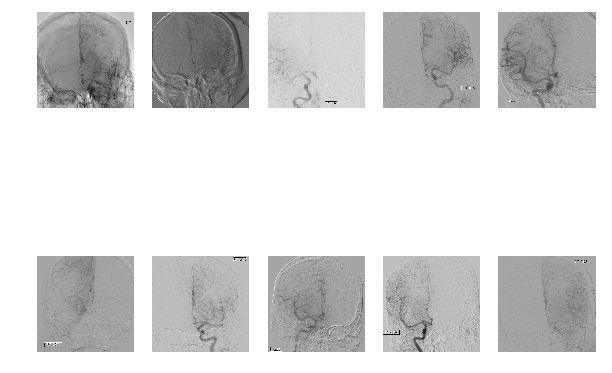

In [79]:
# Let's try to visualize some of these images!
for i in xrange(10):
    plt.subplot(2,5, i+1)
    #im = np.tile(X_all[i,:,:], (3,1,1)).transpose(2,1,0)
    im = X_all[i,:,:]
    imgplot = plt.imshow(im)
    plt.axis('off')

## Where to get the data ##
It's inside of my **preprocessed_data/dataMat/X_all.h5** file. It's approx 1~3 GB's big with about 200 patients infor